## Embedded, interpolated datasets

In [3]:
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds
from yt_xarray.sample_data import load_random_xr_data
import numpy as np 

fields = {
        "field0": ("altitude", "latitude", "longitude"),
    }
dims = {
    "altitude": (100, 5000, 32),
    "latitude": (10, 50, 32),
    "longitude": (10, 50, 22),
}
ds = load_random_xr_data(fields, dims)

gc = GeocentricCartesian(radial_type='altitude', r_o=6371.)
ds_yt = build_interpolated_cartesian_ds(ds, gc, fields='field0')
ad = ds_yt.all_data()
mn = np.nanmin(ad[("stream", "field0")])
mx = np.nanmax(ad[("stream", "field0")])
mn, mx

yt : [INFO     ] 2024-03-14 13:49:41,281 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-14 13:49:41,281 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-03-14 13:49:41,282 Parameters: domain_left_edge          = [2673.  722. 1123.]
yt : [INFO     ] 2024-03-14 13:49:41,283 Parameters: domain_right_edge         = [11029.  8579.  8711.]
yt : [INFO     ] 2024-03-14 13:49:41,284 Parameters: cosmological_simulation   = 0


(unyt_quantity(8.35753745e-05, '(dimensionless)'),
 unyt_quantity(0.99999044, '(dimensionless)'))

yt : [INFO     ] 2024-03-14 13:51:40,669 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-14 13:51:40,670 Parameters: domain_dimensions         = [250 250 250]
yt : [INFO     ] 2024-03-14 13:51:40,671 Parameters: domain_left_edge          = [-6321. -6321. -6321.]
yt : [INFO     ] 2024-03-14 13:51:40,671 Parameters: domain_right_edge         = [6320. 6321. 6321.]
yt : [INFO     ] 2024-03-14 13:51:40,672 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-14 13:51:42,770 xlim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:42,771 ylim = -6321.000000 6320.000000
yt : [INFO     ] 2024-03-14 13:51:42,773 xlim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:42,773 ylim = -6321.000000 6320.000000
yt : [INFO     ] 2024-03-14 13:51:42,775 Making a fixed resolution buffer of (('stream', 'mp')) 800 by 800



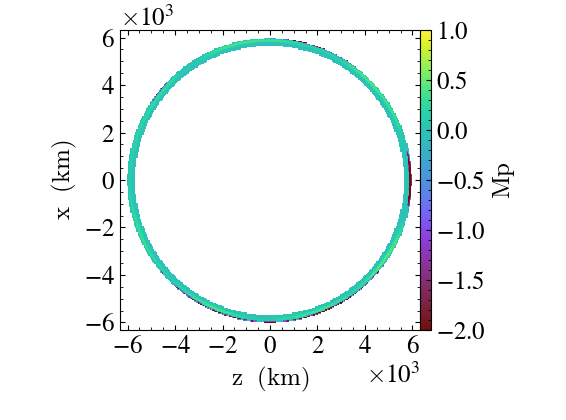

yt : [INFO     ] 2024-03-14 13:51:45,349 xlim = -6321.000000 6320.000000
yt : [INFO     ] 2024-03-14 13:51:45,350 ylim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:45,351 xlim = -6321.000000 6320.000000
yt : [INFO     ] 2024-03-14 13:51:45,352 ylim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:45,353 Making a fixed resolution buffer of (('stream', 'mp')) 800 by 800



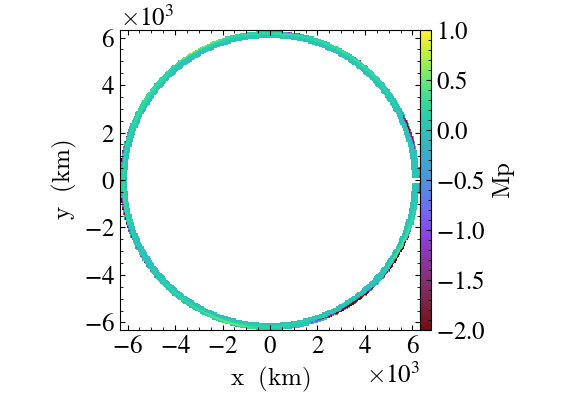

yt : [INFO     ] 2024-03-14 13:51:47,832 xlim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:47,833 ylim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:47,835 xlim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:47,835 ylim = -6321.000000 6321.000000
yt : [INFO     ] 2024-03-14 13:51:47,836 Making a fixed resolution buffer of (('stream', 'mp')) 800 by 800



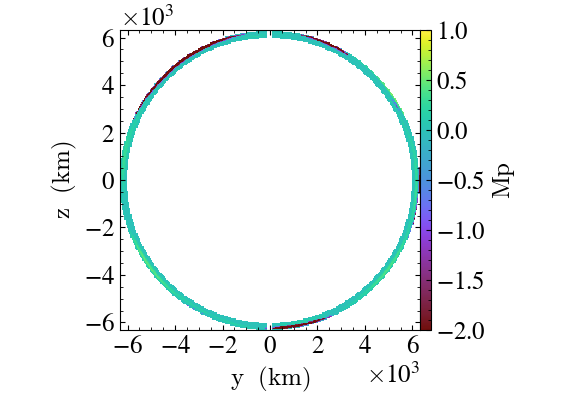

In [8]:
# globa dataset. upper mantle only, need high res to resolve ring
import yt_xarray
import yt
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds
from yt_xarray.sample_data import load_random_xr_data
import numpy as np

ds = yt_xarray.open_dataset("IRIS/DBRD-NATURE2020-depth.r0.1.nc")
gc = GeocentricCartesian(radial_type='depth', 
                         r_o=6371., 
                         use_neg_lons=False)

ds_yt = build_interpolated_cartesian_ds(ds, 
                                        gc, 
                                        fields='mp', 
                                        length_unit='km',
                                        grid_resolution=(250, 250, 250))

c = ds_yt.domain_center.copy()
c[1] = -2000.
slc = yt.SlicePlot(ds_yt, 'y', ('stream', 'mp'), window_size=(3,3), center=c)
slc.set_log(('stream', 'mp'), False)
slc.set_zlim(('stream', 'mp'), -2, 1)
slc.show()

slc = yt.SlicePlot(ds_yt, 'z', ('stream', 'mp'), window_size=(3,3))
slc.set_log(('stream', 'mp'), False)
slc.set_zlim(('stream', 'mp'), -2, 1)
slc.show()

slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'mp'), window_size=(3,3))
slc.set_log(('stream', 'mp'), False)
slc.set_zlim(('stream', 'mp'), -2, 1)
slc.show()

yt_xarray : [INFO ] 2024-03-14 13:52:08,855:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2024-03-14 13:52:08,855:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2024-03-14 13:52:08,856:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2024-03-14 13:52:08,909 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-14 13:52:08,909 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2024-03-14 13:52:08,910 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2024-03-14 13:52:08,910 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2024-03-14 13:52:08,911 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-14 13:52:08,974 xlim = -125.750000 -95.500000
yt : [INFO     ] 2024-03-14 13:52:08,975 ylim = 27.500000 50.500000
yt : [INFO     ] 2024-03-14 13:52:08,975 Setting origin


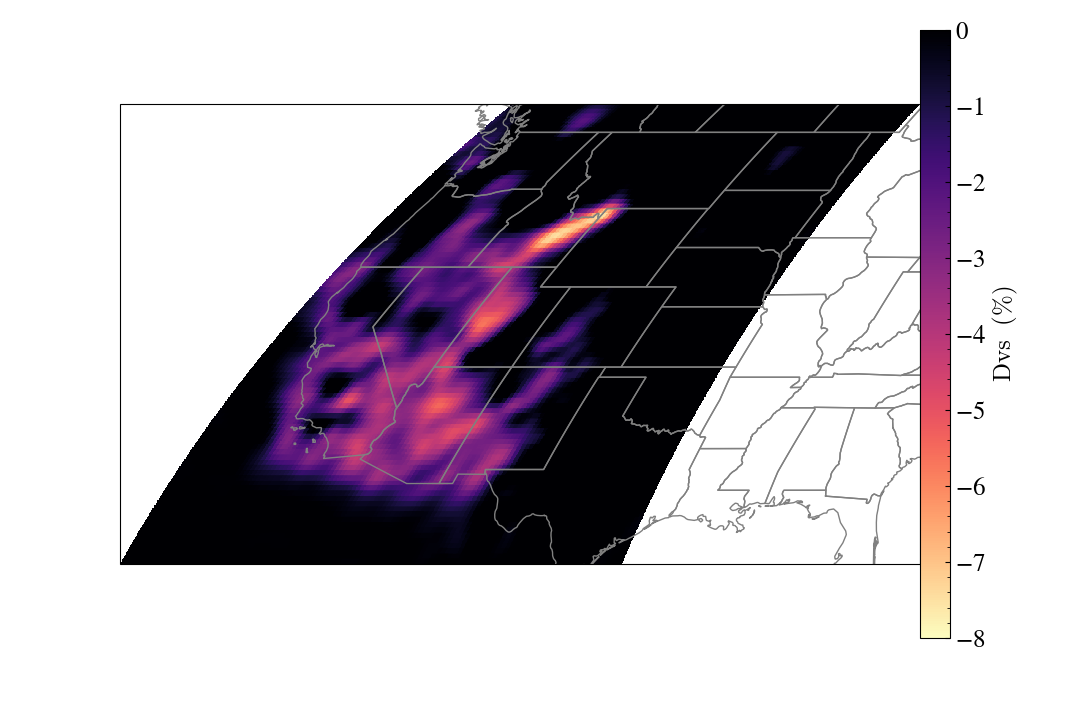

In [9]:
import yt_xarray
import yt
from cartopy.feature import NaturalEarthFeature

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
yt_ds = ds.yt.load_grid(use_callable=True)

c = yt_ds.domain_center.copy()
c[0] = 150.
slc = yt.SlicePlot(yt_ds, "depth", ("stream", "dvs"), center = c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc._setup_plots()

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces')
slc[("stream", "dvs")].axes.add_feature(states, edgecolor='gray')
slc.show()

yt : [INFO     ] 2024-03-14 13:52:17,756 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-14 13:52:17,756 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-03-14 13:52:17,757 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-03-14 13:52:17,757 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-03-14 13:52:17,758 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-14 13:52:18,145 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:18,145 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:18,147 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:18,147 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:18,149 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



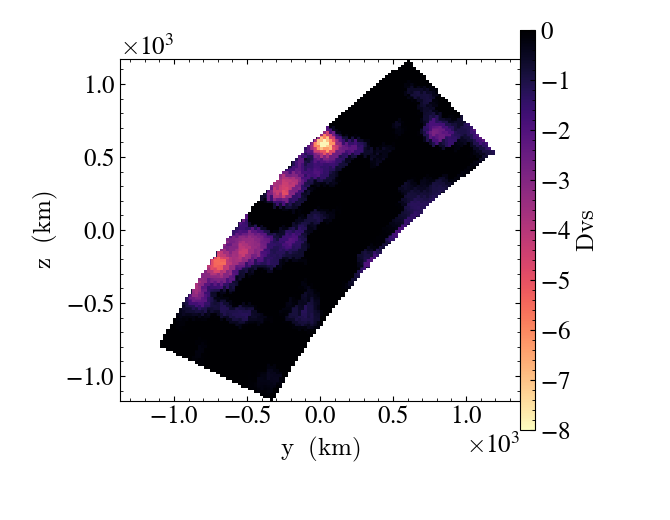

yt : [INFO     ] 2024-03-14 13:52:19,062 xlim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:19,063 ylim = -3271.000000 -334.000000
yt : [INFO     ] 2024-03-14 13:52:19,065 xlim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:19,065 ylim = -3271.000000 -334.000000
yt : [INFO     ] 2024-03-14 13:52:19,066 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



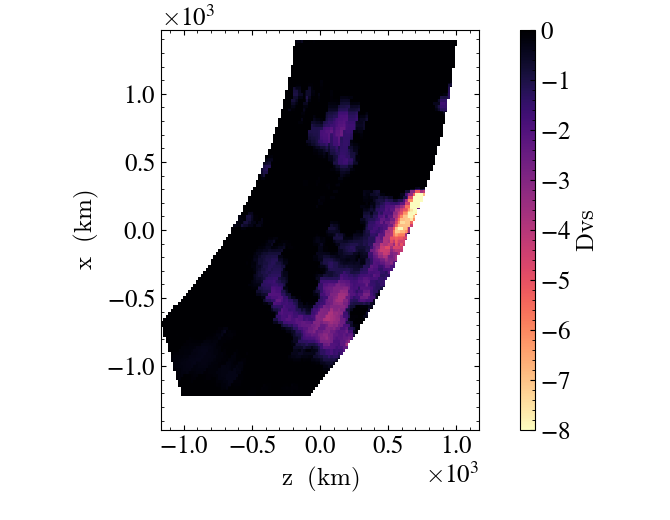

yt : [INFO     ] 2024-03-14 13:52:19,893 xlim = -3271.000000 -334.000000
yt : [INFO     ] 2024-03-14 13:52:19,893 ylim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:19,895 xlim = -3271.000000 -334.000000
yt : [INFO     ] 2024-03-14 13:52:19,896 ylim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:19,897 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



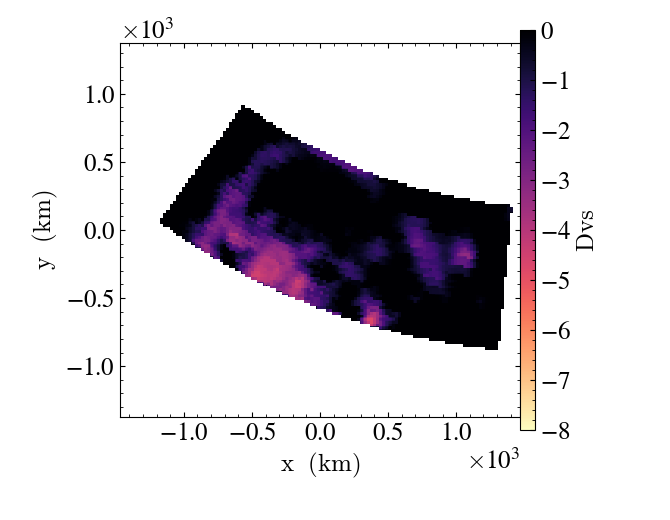

In [10]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")

grid_resolution = (128, 128, 128)
gc = GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = build_interpolated_cartesian_ds(ds, gc, 
                                        fields='dvs', 
                                        length_unit='km',
                                        grid_resolution=grid_resolution)


for ax in ('x', 'y', 'z'):
    slc = yt.SlicePlot(ds_yt, ax, ('stream', 'dvs'), window_size=(4,4))
    slc.set_log(("stream", "dvs"), False)
    slc.set_cmap(("stream", "dvs"), "magma_r")
    slc.set_zlim(("stream", "dvs"), -8, 0)
    slc.show()

yt : [WARNING  ] 2024-03-14 13:52:21,251 Field ('stream', 'slow_dvs') was added without specifying units or dimensions, auto setting units to 'dimensionless'
yt : [INFO     ] 2024-03-14 13:52:21,252 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:21,252 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:21,254 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-03-14 13:52:21,255 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-03-14 13:52:21,256 Making a fixed resolution buffer of (('stream', 'slow_dvs')) 800 by 800



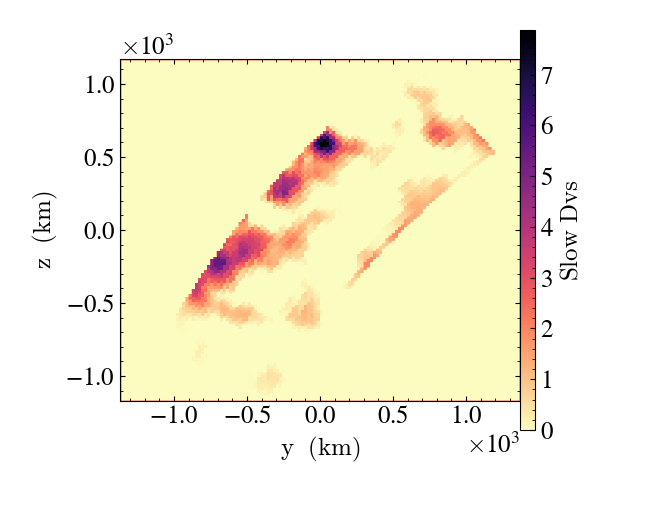

In [11]:

def _slow_vels(field, data):
    # return negative velocities only, 0 all other elements
    dvs = data['stream', 'dvs'].copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return np.abs(dvs)

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'slow_dvs'), window_size=(4,4))
slc.set_log(("stream", "slow_dvs"), False)
slc.set_cmap(("stream", "slow_dvs"), "magma_r")

slc.annotate_grids(edgecolors=(1,0,0,1))
slc.show()

yt : [INFO     ] 2024-03-14 13:52:22,135 Rendering scene (Can take a while).
yt : [INFO     ] 2024-03-14 13:52:22,137 Creating volume
yt : [INFO     ] 2024-03-14 13:52:22,531 Creating transfer function


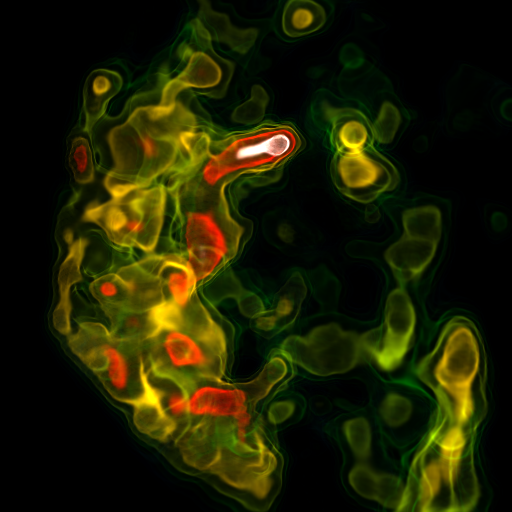

In [12]:
reg = ds_yt.region( ds_yt.domain_center, ds_yt.domain_left_edge, ds_yt.domain_right_edge)
reg

sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))

cam = sc.add_camera(ds_yt)

source = sc[0]

# Set the bounds of the transfer function
source.tfh.set_bounds((0.1, 8))

# set that the transfer function should be evaluated in log space
source.tfh.set_log(True)

# source.tfh.plot("transfer_function.png", profile_field=('stream', 'slow_dvs'))
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)

sc.show(sigma_clip=5.)
# sc.save('WUS_rendering.png', sigma_clip=5., render=False)
